<center><H1>Putting it all together: Py-ART, S3, Siphon, Boto and MetPy</H1></center>

In [47]:
#First out imports
#Lets import some stuff!
from boto.s3.connection import S3Connection
from datetime import timedelta, datetime
import os
import pyart
from matplotlib import pyplot as plt
import tempfile
import numpy as np
import cartopy
from netCDF4 import num2date
from pytz import timezone
import pytz
from siphon.ncss import NCSS
from metpy.plots import StationPlot
from metpy.plots.wx_symbols import sky_cover
from siphon.catalog import TDSCatalog
from metpy.calc import get_wind_components
import metpy.calc
from metpy.units import units
from metpy.plots import simple_layout

%matplotlib inline

In [3]:
#Now our nifty fetch script
#Helper function for the search
def _nearestDate(dates, pivot):
    return min(dates, key=lambda x: abs(x - pivot))


def get_radar_from_aws(site, datetime_t):
    """
    Get the closest volume of NEXRAD data to a particular datetime.
    Parameters
    ----------
    site : string
        four letter radar designation
    datetime_t : datetime
        desired date time
    Returns
    -------
    radar : Py-ART Radar Object
        Radar closest to the queried datetime
    """

    #First create the query string for the bucket knowing
    #how NOAA and AWS store the data

    my_pref = datetime_t.strftime('%Y/%m/%d/') + site

    #Connect to the bucket

    conn = S3Connection(anon = True)
    bucket = conn.get_bucket('noaa-nexrad-level2')

    #Get a list of files

    bucket_list = list(bucket.list(prefix = my_pref))

    #we are going to create a list of keys and datetimes to allow easy searching

    keys = []
    datetimes = []

    #populate the list

    for i in range(len(bucket_list)):
        this_str = str(bucket_list[i].key)
        if 'gz' in this_str:
            endme = this_str[-22:-4]
            fmt = '%Y%m%d_%H%M%S_V0'
            dt = datetime.strptime(endme, fmt)
            datetimes.append(dt)
            keys.append(bucket_list[i])

        if this_str[-3::] == 'V06':
            endme = this_str[-19::]
            fmt = '%Y%m%d_%H%M%S_V06'
            dt = datetime.strptime(endme, fmt)
            datetimes.append(dt)
            keys.append(bucket_list[i])

    #find the closest available radar to your datetime

    closest_datetime = _nearestDate(datetimes, datetime_t)
    index = datetimes.index(closest_datetime)

    localfile = tempfile.NamedTemporaryFile()
    keys[index].get_contents_to_filename(localfile.name)
    radar = pyart.io.read(localfile.name)
    return radar

In [103]:
#Lets grab the latest radar volume from Seattle
station = 'KATX'
my_datetime = datetime.utcnow()
radar = get_radar_from_aws(station, my_datetime)

In [104]:
#Lets get some geographical context
lats = radar.gate_latitude
lons = radar.gate_longitude

min_lon = lons['data'].min()
min_lat = lats['data'].min()
max_lat = lats['data'].max()
max_lon = lons['data'].max()

print('min_lat:', min_lat, ' min_lon:', min_lon, 
      ' max_lat:', max_lat, ' max_lon:', max_lon)

sweep = 0
index_at_start = radar.sweep_start_ray_index['data'][sweep]
time_at_start_of_radar = num2date(radar.time['data'][index_at_start], 
                                  radar.time['units'])
pacific = timezone('US/Pacific')
local_time = pacific.fromutc(time_at_start_of_radar)
fancy_date_string = local_time.strftime('%A %B %d at %I:%M %p %Z')
print(fancy_date_string)

min_lat: 44.0651513329  min_lon: -128.697261032  max_lat: 52.3240653229  max_lon: -116.294130506
Friday January 20 at 11:15 AM PST


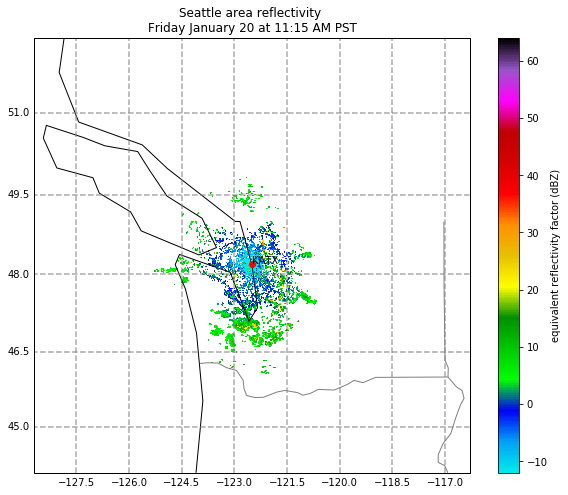

In [105]:
fig = plt.figure(figsize = [10,8])
display = pyart.graph.RadarMapDisplayCartopy(radar)
lat_0 = display.loc[0]
lon_0 = display.loc[1]

#Main difference! Cartopy forces you to select a projection first!
projection = cartopy.crs.Mercator(
                central_longitude=lon_0,
                min_latitude=min_lat, max_latitude=max_lat)

title = 'Seattle area reflectivity \n' + fancy_date_string

display.plot_ppi_map(
    'reflectivity', 0, colorbar_flag=True,
    title=title,
    projection=projection,
    min_lon=min_lon, max_lon=max_lon, min_lat=min_lat, max_lat=max_lat,
    vmin=-12, vmax=64)

#Mark the radar
display.plot_point(lon_0, lat_0, label_text='KATX')

#Get the current axes and plot some lat and lon lines
ax = plt.gca()
gl = ax.gridlines( draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False


In [108]:
# copied from the browser url box
metar_cat_url = 'http://thredds.ucar.edu/thredds/catalog/nws/metar/ncdecoded/catalog.xml?dataset=nws/metar/ncdecoded/Metar_Station_Data_fc.cdmr'
# parse the xml
metar_cat = TDSCatalog(metar_cat_url)
# what datasets are here? only one "dataset" in this catalog
dataset = list(metar_cat.datasets.values())[0]
print(dataset.name)
ncss_url = dataset.access_urls["NetcdfSubset"]
ncss = NCSS(ncss_url)

start_time = my_datetime - timedelta(days=1)


Feature Collection


In [109]:
bb = {'north' : max_lat,
      'south' : min_lat,
      'east' : max_lon,
      'west' : min_lon}

query = ncss.query()
query.lonlat_box(north=bb['north'], south=bb['south'], east=bb['east'], west=bb['west'])
query.time(start_time)
query.variables('air_temperature', 'dew_point_temperature', 'inches_ALTIM',
                'wind_speed', 'wind_from_direction', 'cloud_area_fraction')
query.accept('csv')

var=wind_speed&var=inches_ALTIM&var=wind_from_direction&var=cloud_area_fraction&var=air_temperature&var=dew_point_temperature&time=2017-01-19T19%3A29%3A48.526990&west=-128.697261032&north=52.3240653229&south=44.0651513329&east=-116.294130506&accept=csv

In [110]:

data = ncss.get_data(query)

# Access is just like netcdf4-python
lats = data['latitude'][:]
lons = data['longitude'][:]
tair = data['air_temperature'][:]
dewp = data['dew_point_temperature'][:]
slp = (data['inches_ALTIM'][:] * units('inHg')).to('mbar')

# Convert wind to components
u, v = get_wind_components(data['wind_speed'], np.deg2rad(data['wind_from_direction']))

# Need to handle missing (NaN) and convert to proper code
cloud_cover = 8 * data['cloud_area_fraction']
cloud_cover[np.isnan(cloud_cover)] = 9
cloud_cover = cloud_cover.astype(np.int)

# For some reason these come back as bytes instead of strings
stid = [s.decode() for s in data['station']]

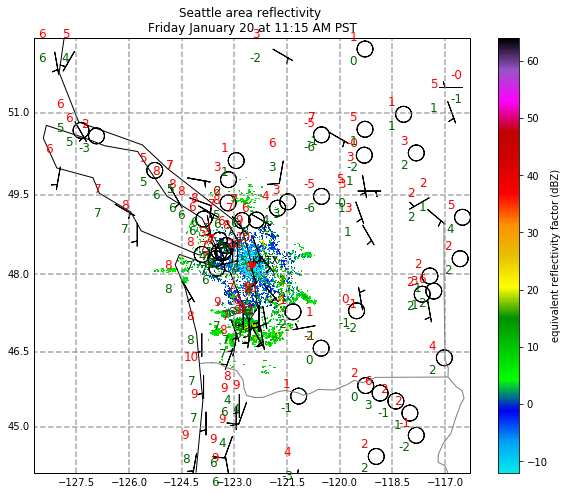

In [111]:
fig = plt.figure(figsize = [10,8])
display = pyart.graph.RadarMapDisplayCartopy(radar)
lat_0 = display.loc[0]
lon_0 = display.loc[1]

#Main difference! Cartopy forces you to select a projection first!
projection = cartopy.crs.Mercator(
                central_longitude=lon_0,
                min_latitude=min_lat, max_latitude=max_lat)

title = 'Seattle area reflectivity \n' + fancy_date_string

display.plot_ppi_map(
    'reflectivity', 0, colorbar_flag=True,
    title=title,
    projection=projection,
    min_lon=min_lon, max_lon=max_lon, min_lat=min_lat, max_lat=max_lat,
    vmin=-12, vmax=64)

#Mark the radar
display.plot_point(lon_0, lat_0, label_text='KATX')

#Get the current axes and plot some lat and lon lines
ax = plt.gca()
gl = ax.gridlines( draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False

stationplot = StationPlot(ax, lons, lats, transform=cartopy.crs.PlateCarree(),
                          fontsize=12)

stationplot.plot_parameter('NW', tair, color='red')
stationplot.plot_parameter('SW', dewp, color='darkgreen')

# Add wind barbs
stationplot.plot_barb(u, v)

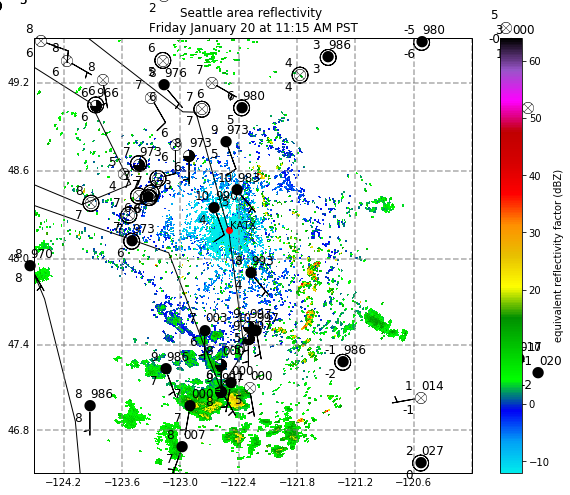

In [113]:

sfc_data = {'air_temperature': tair, 'dew_point_temperature': dewp, 'eastward_wind': u,
            'northward_wind': v, 'cloud_coverage': cloud_cover,
            'air_pressure_at_sea_level': slp}

fig = plt.figure(figsize = [10,8])
display = pyart.graph.RadarMapDisplayCartopy(radar)
lat_0 = display.loc[0]
lon_0 = display.loc[1]

#Main difference! Cartopy forces you to select a projection first!
projection = cartopy.crs.Mercator(
                central_longitude=lon_0,
                min_latitude=min_lat, max_latitude=max_lat)

title = 'Seattle area reflectivity \n' + fancy_date_string

display.plot_ppi_map(
    'reflectivity', 0, colorbar_flag=True,
    title=title,
    projection=projection,
    min_lon=-124.5, max_lon=-120, min_lat=46.5, max_lat=49.5,
    vmin=-12, vmax=64)

#Mark the radar
display.plot_point(lon_0, lat_0, label_text='KATX')

#Get the current axes and plot some lat and lon lines
ax = plt.gca()
gl = ax.gridlines( draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False

stationplot = StationPlot(ax, lons, lats, transform=cartopy.crs.PlateCarree(),
                          fontsize=12)

simple_layout.plot(stationplot, sfc_data)

min_lat: 26.5499873276  min_lon: -93.0429753145  max_lat: 34.8089130166  max_lon: -83.4370187668
Friday January 20 at 11:27 AM PST
Feature Collection


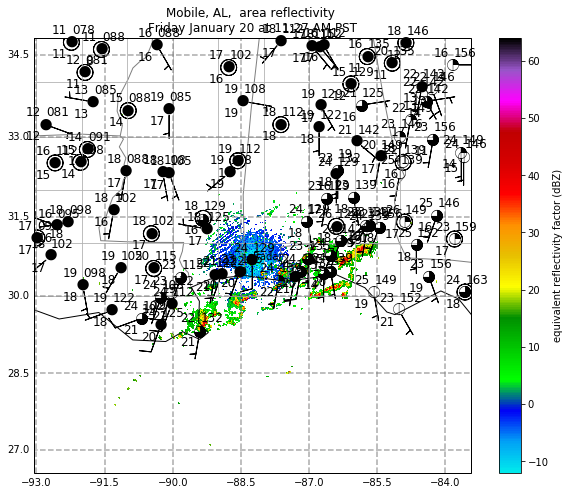

In [114]:
# All together now!
station = 'KMOB'
radar_title = 'Mobile, AL, '
my_datetime = datetime.utcnow()
radar = get_radar_from_aws(station, my_datetime)

#Lets get some geographical context
lats = radar.gate_latitude
lons = radar.gate_longitude

min_lon = lons['data'].min()
min_lat = lats['data'].min()
max_lat = lats['data'].max()
max_lon = lons['data'].max()

print('min_lat:', min_lat, ' min_lon:', min_lon, 
      ' max_lat:', max_lat, ' max_lon:', max_lon)

sweep = 0
index_at_start = radar.sweep_start_ray_index['data'][sweep]
time_at_start_of_radar = num2date(radar.time['data'][index_at_start], 
                                  radar.time['units'])
pacific = timezone('US/Pacific')
local_time = pacific.fromutc(time_at_start_of_radar)
fancy_date_string = local_time.strftime('%A %B %d at %I:%M %p %Z')
print(fancy_date_string)

# copied from the browser url box
metar_cat_url = 'http://thredds.ucar.edu/thredds/catalog/nws/metar/ncdecoded/catalog.xml?dataset=nws/metar/ncdecoded/Metar_Station_Data_fc.cdmr'
# parse the xml
metar_cat = TDSCatalog(metar_cat_url)
# what datasets are here? only one "dataset" in this catalog
dataset = list(metar_cat.datasets.values())[0]
print(dataset.name)
ncss_url = dataset.access_urls["NetcdfSubset"]
ncss = NCSS(ncss_url)

start_time = my_datetime - timedelta(days=1)
bb = {'north' : max_lat,
      'south' : min_lat,
      'east' : max_lon,
      'west' : min_lon}

query = ncss.query()
query.lonlat_box(north=bb['north'], south=bb['south'], east=bb['east'], west=bb['west'])
query.time(start_time)
query.variables('air_temperature', 'dew_point_temperature', 'inches_ALTIM',
                'wind_speed', 'wind_from_direction', 'cloud_area_fraction')
query.accept('csv')


data = ncss.get_data(query)

# Access is just like netcdf4-python
lats = data['latitude'][:]
lons = data['longitude'][:]
tair = data['air_temperature'][:]
dewp = data['dew_point_temperature'][:]
slp = (data['inches_ALTIM'][:] * units('inHg')).to('mbar')

# Convert wind to components
u, v = get_wind_components(data['wind_speed'], np.deg2rad(data['wind_from_direction']))

# Need to handle missing (NaN) and convert to proper code
cloud_cover = 8 * data['cloud_area_fraction']
cloud_cover[np.isnan(cloud_cover)] = 9
cloud_cover = cloud_cover.astype(np.int)

# For some reason these come back as bytes instead of strings
stid = [s.decode() for s in data['station']]


sfc_data = {'air_temperature': tair, 'dew_point_temperature': dewp, 'eastward_wind': u,
            'northward_wind': v, 'cloud_coverage': cloud_cover,
            'air_pressure_at_sea_level': slp}

fig = plt.figure(figsize = [10,8])
display = pyart.graph.RadarMapDisplayCartopy(radar)
lat_0 = display.loc[0]
lon_0 = display.loc[1]

#Main difference! Cartopy forces you to select a projection first!
projection = cartopy.crs.Mercator(
                central_longitude=lon_0,
                min_latitude=min_lat, max_latitude=max_lat)

title = radar_title +' area reflectivity \n' + fancy_date_string

display.plot_ppi_map(
    'reflectivity', 0, colorbar_flag=True,
    title=title,
    projection=projection,
    min_lon=min_lon, max_lon=max_lon, min_lat=min_lat, max_lat=max_lat,
    vmin=-12, vmax=64)

#Mark the radar
display.plot_point(lon_0, lat_0, label_text='Radar')

#Get the current axes and plot some lat and lon lines
ax = plt.gca()
gl = ax.gridlines( draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False

stationplot = StationPlot(ax, lons, lats, transform=cartopy.crs.PlateCarree(),
                          fontsize=12)

simple_layout.plot(stationplot, sfc_data)

In [115]:
#and finally we can make it into a function
def radar_plus_obs(station, my_datetime, 
                   radar_title=None, bb=None):
    # All together now!
    #Lets grab the latest radar volume from Seattle
    if radar_title is None:
        radar_title = 'Area '
    
    radar = get_radar_from_aws(station, my_datetime)

    #Lets get some geographical context
    if bb is None:
        lats = radar.gate_latitude
        lons = radar.gate_longitude

        min_lon = lons['data'].min()
        min_lat = lats['data'].min()
        max_lat = lats['data'].max()
        max_lon = lons['data'].max()
        bb = {'north' : max_lat,
              'south' : min_lat,
              'east' : max_lon,
              'west' : min_lon}
    else:
        min_lon = bb['west']
        min_lat = bb['south']
        max_lon = bb['east']
        max_lat = bb['north']
        

    print('min_lat:', min_lat, ' min_lon:', min_lon, 
          ' max_lat:', max_lat, ' max_lon:', max_lon)

    sweep = 0
    index_at_start = radar.sweep_start_ray_index['data'][sweep]
    time_at_start_of_radar = num2date(radar.time['data'][index_at_start], 
                                      radar.time['units'])
    pacific = timezone('US/Pacific')
    local_time = pacific.fromutc(time_at_start_of_radar)
    fancy_date_string = local_time.strftime('%A %B %d at %I:%M %p %Z')
    print(fancy_date_string)

    # copied from the browser url box
    metar_cat_url = 'http://thredds.ucar.edu/thredds/catalog/nws/metar/ncdecoded/catalog.xml?dataset=nws/metar/ncdecoded/Metar_Station_Data_fc.cdmr'
    # parse the xml
    metar_cat = TDSCatalog(metar_cat_url)
    # what datasets are here? only one "dataset" in this catalog
    dataset = list(metar_cat.datasets.values())[0]
    print(dataset.name)
    ncss_url = dataset.access_urls["NetcdfSubset"]
    ncss = NCSS(ncss_url)

    start_time = my_datetime - timedelta(days=1)
    
    query = ncss.query()
    query.lonlat_box(north=bb['north'], south=bb['south'], east=bb['east'], west=bb['west'])
    query.time(start_time)
    query.variables('air_temperature', 'dew_point_temperature', 'inches_ALTIM',
                    'wind_speed', 'wind_from_direction', 'cloud_area_fraction')
    query.accept('csv')


    data = ncss.get_data(query)

    # Access is just like netcdf4-python
    lats = data['latitude'][:]
    lons = data['longitude'][:]
    tair = data['air_temperature'][:]
    dewp = data['dew_point_temperature'][:]
    slp = (data['inches_ALTIM'][:] * units('inHg')).to('mbar')

    # Convert wind to components
    u, v = get_wind_components(data['wind_speed'], np.deg2rad(data['wind_from_direction']))

    # Need to handle missing (NaN) and convert to proper code
    cloud_cover = 8 * data['cloud_area_fraction']
    cloud_cover[np.isnan(cloud_cover)] = 9
    cloud_cover = cloud_cover.astype(np.int)

    # For some reason these come back as bytes instead of strings
    stid = [s.decode() for s in data['station']]


    sfc_data = {'air_temperature': tair, 'dew_point_temperature': dewp, 'eastward_wind': u,
                'northward_wind': v, 'cloud_coverage': cloud_cover,
                'air_pressure_at_sea_level': slp}

    fig = plt.figure(figsize = [10,8])
    display = pyart.graph.RadarMapDisplayCartopy(radar)
    lat_0 = display.loc[0]
    lon_0 = display.loc[1]

    #Main difference! Cartopy forces you to select a projection first!
    projection = cartopy.crs.Mercator(
                    central_longitude=lon_0,
                    min_latitude=min_lat, max_latitude=max_lat)

    title = radar_title +' area reflectivity \n' + fancy_date_string

    display.plot_ppi_map(
        'reflectivity', 0, colorbar_flag=True,
        title=title,
        projection=projection,
        min_lon=min_lon, max_lon=max_lon, min_lat=min_lat, max_lat=max_lat,
        vmin=-12, vmax=64)

    #Mark the radar
    display.plot_point(lon_0, lat_0, label_text='Radar')

    #Get the current axes and plot some lat and lon lines
    ax = plt.gca()
    gl = ax.gridlines( draw_labels=True,
                      linewidth=2, color='gray', alpha=0.5, linestyle='--')
    gl.xlabels_top = False
    gl.ylabels_right = False

    stationplot = StationPlot(ax, lons, lats, transform=cartopy.crs.PlateCarree(),
                              fontsize=12)

    simple_layout.plot(stationplot, sfc_data)

min_lat: 35.8172353163  min_lon: -79.800991009  max_lat: 44.0769403078  max_lon: -69.0207226556
Friday January 20 at 11:23 AM PST
Feature Collection


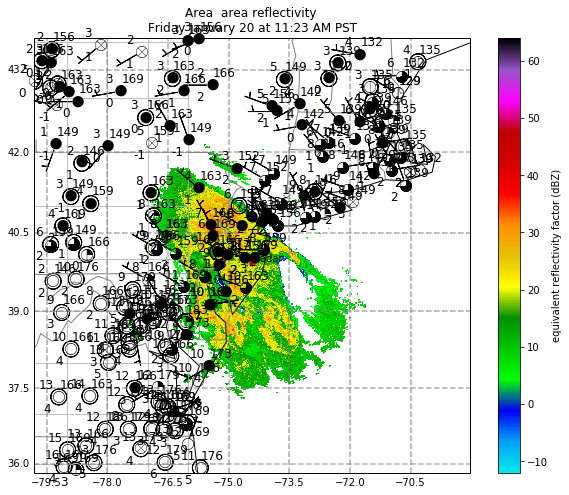

In [116]:
radar_plus_obs('KDIX', datetime.utcnow())

min_lat: 37.4749769482  min_lon: -93.6108094969  max_lat: 45.733897142  max_lon: -82.558344619
Friday January 20 at 11:19 AM PST
Feature Collection


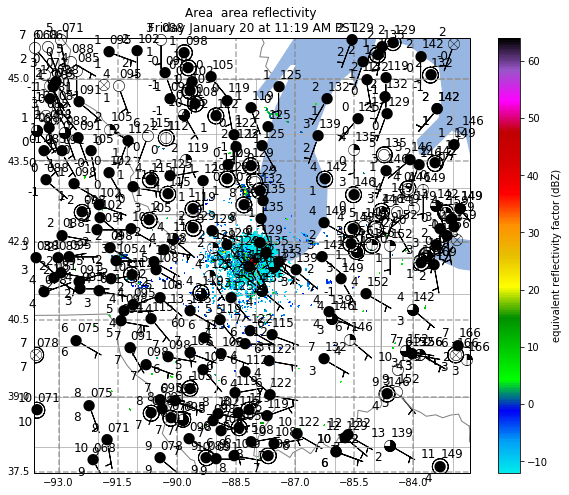

In [117]:
radar_plus_obs('KLOT', datetime.utcnow())
plt.gca().add_feature(cartopy.feature.LAKES, zorder=0)


min_lat: 40.5  min_lon: -88.5  max_lat: 44  max_lon: -85.0
Friday January 20 at 11:19 AM PST
Feature Collection


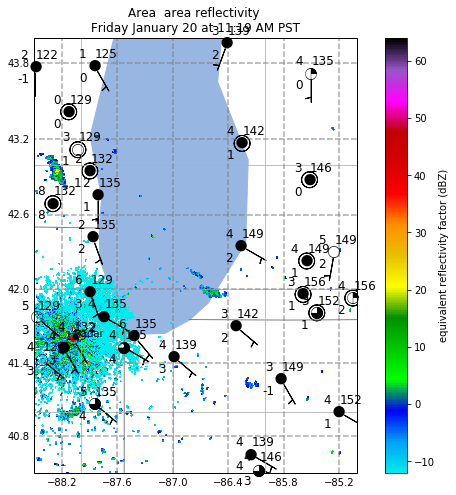

In [118]:
radar_plus_obs('KLOT', datetime.utcnow(), 
               bb={'west':-88.5, 'east':-85.0,'north':44, 'south':40.5})
plt.gca().add_feature(cartopy.feature.LAKES, zorder=0)

Now it's your turn!
==========